In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from collections import Counter
import json, urllib2, sqlite3
import pandas as pd
from IPython.core.display import display, HTML

In [2]:
import matplotlib
def hide_spines():
    """Hides the top and rightmost axis spines from view for all active
    figures and their respective axes."""

    # Retrieve a list of all current figures.
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.spines['left'].set_color('none')
            ax.spines['bottom'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')

In [3]:
candidate = 'clinton'

In [5]:
# data_downsampled = np.genfromtxt('data_'+candidate+'_downsampled.csv', delimiter=',')
conn = sqlite3.connect('../data backup/data_downsampled.sqlite')
c = conn.cursor()
c.execute('''SELECT * FROM '''+candidate+''' WHERE datetime > 1459456469;''')
data_downsampled = c.fetchall()
conn.close()

In [81]:
# %%capture
# data = np.genfromtxt('data_clinton_00000.csv', delimiter=',', usecols=(0,1,2), invalid_raise=False, loose=True);

In [82]:
data = pd.read_csv('data_'+candidate+'_00000.csv', header=None,
                   names=['date', 'sentiment', 'tweetID'],
                   dtype={'date': np.float64, 'senitiment': np.float64, 'tweetID': str})

In [83]:
data = data.dropna()

In [84]:
data_downsampled = np.array([d for d in data_downsampled if d[0] >= data.at[data.index[0], 'date']])

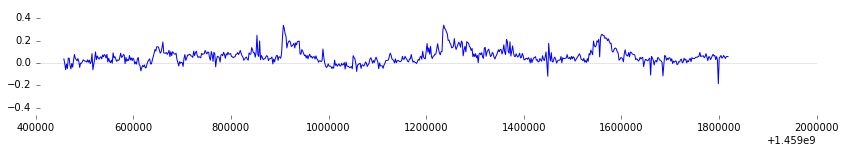

In [85]:
plt.figure(figsize=(14,2))
plt.plot(data_downsampled[:,0], data_downsampled[:,1])
plt.axhline(y=0, c='black', alpha=0.1)
plt.ylim([-0.5, 0.5])
hide_spines()

# Alternative peak detection

In [86]:
# alternative peak detection
# inspired by: http://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data
from collections import deque
def real_get_peaks(data, threshold=3, lag=48, deadzone=1): # some PHP nostalgia
    means = []
    stds = []
    baseline_values = deque(data[:lag])
    mean = np.mean(baseline_values)
    means_signal = [mean]*lag
    std = np.std(baseline_values)
    means.extend([mean]*lag)
    stds.extend([std]*lag)
    peaks = []
    peaking = False
    start = None
    i = lag
    for d in data[lag:]:
        new_mean = np.mean(data[i-lag:i])
        means_signal.append(new_mean)
        if not peaking:
            if np.abs(d - mean) > std*threshold:
                # peak detected
                peaking = True
                start = i
            else:
                # calculate new moving mean and std
                baseline_values.popleft()
                baseline_values.append(d)
                mean = np.mean(baseline_values)
                std = np.std(baseline_values)
        elif peaking:
            if np.abs(d - mean) < std*(threshold-deadzone):
                peaks.append([start, i])
                peaking = False
                start = None
        means.append(mean)
        stds.append(std)
        i += 1
    return peaks, np.array(means), np.array(stds), means_signal

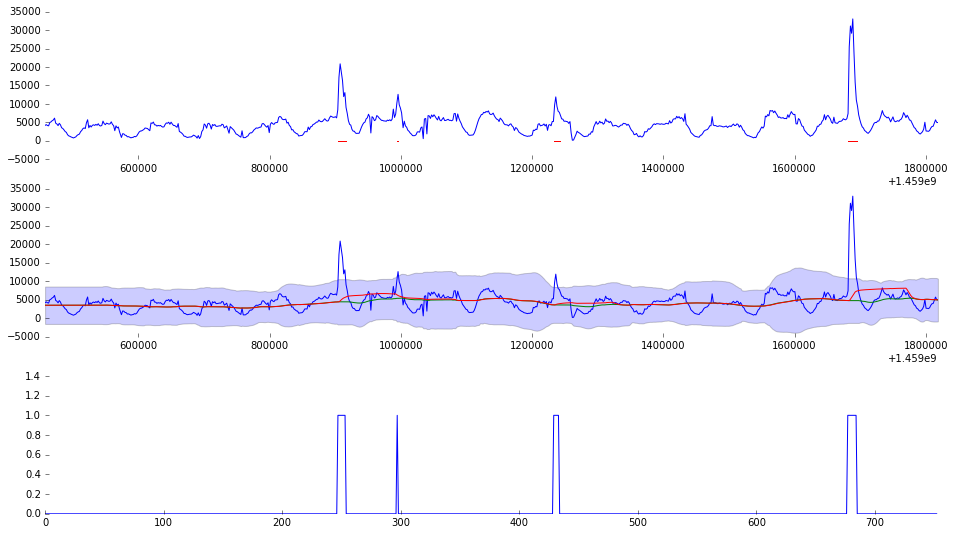

In [87]:
threshold = 3.5
peaks, means, stds, means_signal = real_get_peaks(data_downsampled[:,2], threshold=threshold)

peaks_signal = np.zeros_like(means)
for p in peaks:
    peaks_signal[p[0]:p[1]] = 1

plt.figure(figsize=(16,9))
plt.subplot(311)
for p in peaks:
    plt.axhline(y=-.4, xmin=p[0]/len(means), xmax=p[1]/len(means), c='r')
for p in peaks:
    p[0] = data_downsampled[p[0],0]
    p[1] = data_downsampled[p[1],0]
plt.plot(data_downsampled[:,0], data_downsampled[:,2])
# plt.ylim([-0.5,0.5])
plt.xlim([data_downsampled[0,0],data_downsampled[-1,0]])

plt.subplot(312)
plt.plot(data_downsampled[:,0], data_downsampled[:,2])
plt.xlim([data_downsampled[0,0],data_downsampled[-1,0]])
plt.plot(data_downsampled[:,0], means)
plt.fill_between(data_downsampled[:,0], means+stds*threshold, means-stds*threshold, alpha=0.2)
plt.plot(data_downsampled[:,0], means_signal)
plt.xlim([data_downsampled[0,0],data_downsampled[-1,0]])

plt.subplot(313)
plt.plot(peaks_signal)
plt.ylim([0,1.5])
plt.xlim([0,len(peaks_signal)])
hide_spines()
plt.show()

# Derivative

In [88]:
def diff_smooth(x, n):
    a = np.zeros_like(x)
    for i in range(len(x)-n):
        i += n
        a[i] = np.nanmean(x[i:i+n], axis=0) - np.nanmean(x[i-n:i], axis=0)
    return a

In [89]:
data_diff = data_downsampled.copy()
data_diff[:,1] = np.abs(diff_smooth(data_downsampled[:,1], 10))
data_diff[:,2] = diff_smooth(data_downsampled[:,2], 2)
# data_diff = np.array([data_downsampled[:len(data_diff),0], data_diff[:,0], data_diff[:,1]])

In [90]:
# peak detection
def get_peaks(x, threshold):
    peaks = []
    peaking = False
    start = None
    for a in x:
        if not peaking:
            if a[1] > threshold:
                start = a[0]
                peaking = True
        elif peaking:
            if a[1] < threshold:
                end = a[0]
                peaks.append([start, end])
                start = None
                peaking = False
    return np.array(peaks)

In [91]:
sentiment_diff_threshold = np.std(data_diff[:,1])*3
tps_diff_threshold = np.std(data_diff[:,2])*2
sentiment_diff_peaks = get_peaks(data_diff[:,[0,1]], sentiment_diff_threshold)
tps_diff_peaks = get_peaks(data_diff[:,[0,2]], tps_diff_threshold)
# sentiment_diff_peaks = real_get_peaks(data_diff[:,1], threshold=1)
# print sentiment_diff_peaks
# for p in sentiment_diff_peaks:
#     p[0] = data_diff[p[0],0]
#     p[1] = data_diff[p[1],0]
# tps_diff_peaks = real_get_peaks(data_diff[:,2], threshold=1)
# for p in tps_diff_peaks:
#     p[0] = data_diff[p[0],0]
#     p[1] = data_diff[p[1],0]

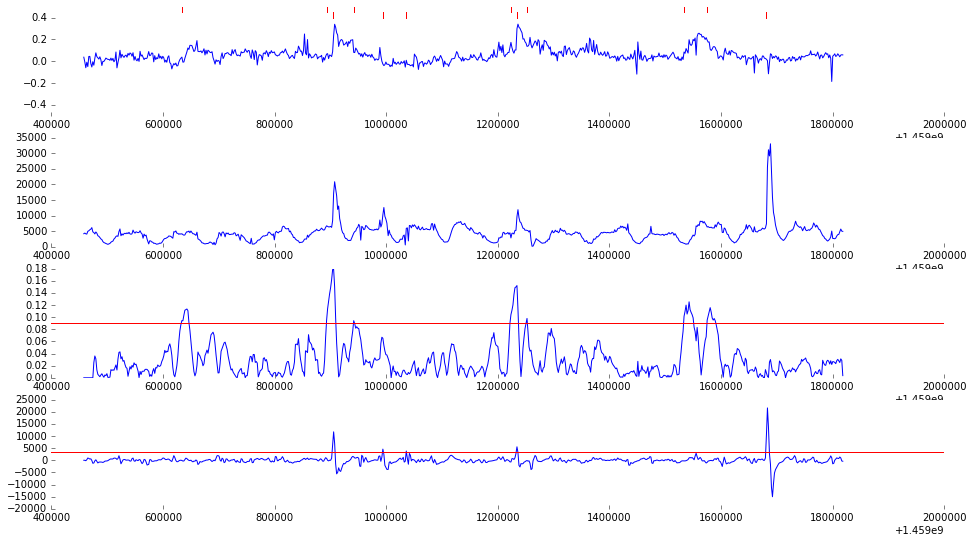

In [101]:
plt.figure(figsize=(16,9))
plt.subplot(411)
plt.plot(data_downsampled[:,0], data_downsampled[:,1])
for p in sentiment_diff_peaks:
    plt.axvline(x=p[0], ymin=0.95, ymax=1, c='r')
for p in tps_diff_peaks:
    plt.axvline(x=p[0], ymin=0.9, ymax=0.95, c='r')
plt.ylim([-0.5,0.5])
plt.subplot(412)
plt.plot(data_downsampled[:,0], data_downsampled[:,2])
plt.subplot(413)
plt.plot(data_diff[:,0], data_diff[:,1])
plt.axhline(y=sentiment_diff_threshold, c='r')
plt.subplot(414)
plt.plot(data_diff[:,0], data_diff[:,2])
plt.axhline(y=tps_diff_threshold, c='r')
hide_spines()
# plt.tight_layout()
plt.show()

In [69]:
# find and display trending tweets
# peaks = np.sort(np.vstack((sentiment_diff_peaks, tps_diff_peaks)), axis=0)

top_tweets = []

prev_top_tweet = None
for i in range(len(peaks)):
    p = peaks[i]
    # get data points within this peak
    b = data.loc[(data['date'] > p[0]) & (data['date'] < p[1])]
    # get most common tweet ID
    top_tweet = b['tweetID'].value_counts().index
    if len(top_tweet) > 0:
        top_tweet = top_tweet[0]
    else:
        continue
    # check if same tweet as previous peak
    if prev_top_tweet and top_tweet == prev_top_tweet:
        print 'same top tweet as previous'
        continue
    prev_top_tweet = top_tweet
    top_tweets.append({'datetime': p[0], 'tweetID': top_tweet})

for t in top_tweets:
    url = 'https://api.twitter.com/1/statuses/oembed.json?id='+t['tweetID']
    try:
        response = urllib2.urlopen(url)
    except:
        print "page doesn't exist: "+str(url)
        continue
    tweet = json.loads((response.read()))
    display(HTML(tweet['html']))

same top tweet as previous
page doesn't exist: https://api.twitter.com/1/statuses/oembed.json?id=717519003309223937


In [65]:
with open('viraltweets.json', 'w') as f:
    json.dump(top_tweets, f, indent=4)

# Tweets per second filter

In [136]:
tps = data_downsampled[:,[0,2]]
tps[:,1] = tps[:,1] / 10 / 60
tps_threshold = np.nanpercentile(tps[:,1], 95)
peaks = get_peaks(tps, tps_threshold)

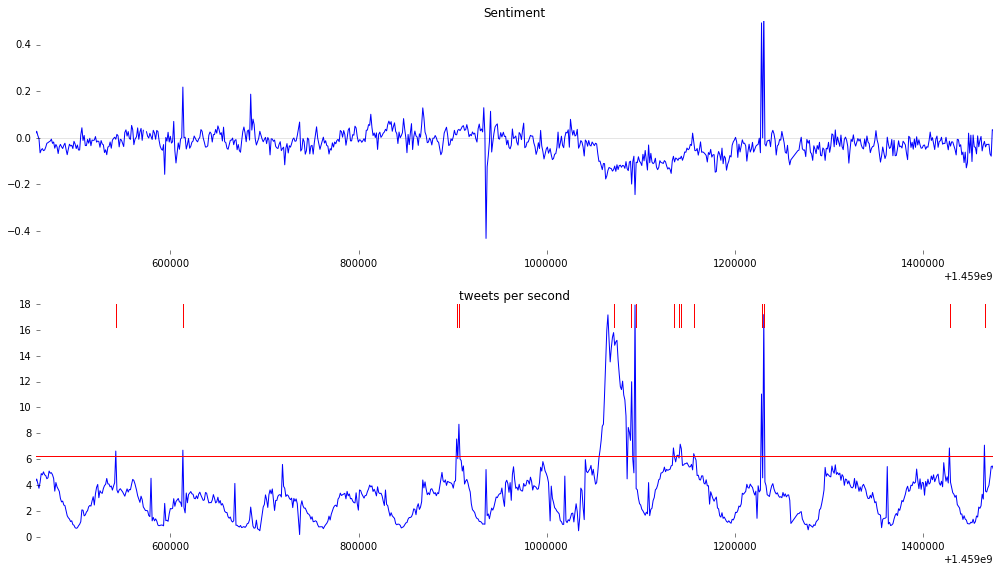

In [137]:
axes = []
plt.figure(figsize=(14,8))
plt.subplot(211)
plt.title('Sentiment')
plt.plot(data_downsampled[:,0], data_downsampled[:,1])
plt.axhline(y=0, c='black', alpha=0.1)
plt.ylim([-0.5, 0.5])
plt.xlim([data_downsampled[0,0], data_downsampled[-1,0]])
plt.subplot(212)
plt.title('tweets per second')
plt.plot(tps[:,0], tps[:,1])
plt.xlim([data_downsampled[0,0], data_downsampled[-1,0]])
plt.axhline(y=tps_threshold, c='r')
for p in peaks:
    plt.axvline(x=np.mean(p), ymin=0.9, ymax=1, c='r')
    
hide_spines()
plt.tight_layout()
plt.show()

In [95]:
# find and display trending tweets
top_tweets = []

prev_top_tweet = None
for i in range(len(peaks)):
    p = peaks[i]
    # get data points within this peak
    b = data.loc[(data['date'] > p[0]) & (data['date'] < p[1])]
    # get most common tweet ID
    top_tweet = b['tweetID'].value_counts().index[0]
    # check if same tweet as previous peak
    if prev_top_tweet and top_tweet == prev_top_tweet:
        print 'same top tweet as previous'
        continue
    prev_top_tweet = top_tweet
    top_tweets.append({'datetime': np.mean(p), 'tweetID': top_tweet})

same top tweet as previous


In [97]:
# # save to json file
# with open('toptweets.json', 'w') as f:
#     json.dump(top_tweets, f, indent=0)

In [98]:
# # save to csv file
# import csv
# with open('toptweets.csv', 'w') as csvfile:
#     fieldnames = ['datetime', 'tweetID']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
#     writer.writeheader()
#     for t in top_tweets:
#         writer.writerow(t)

In [99]:
for t in top_tweets:
    url = 'https://api.twitter.com/1/statuses/oembed.json?id='+t['tweetID']
    try:
        response = urllib2.urlopen(url)
    except:
        print "page doesn't exist: "+str(url)
        continue
    tweet = json.loads((response.read()))
    display(HTML(tweet['html']))

# Mode

In [ ]:
from scipy.stats import mode

In [ ]:
modes = []
tweetids = []
tweets = 0
min_tweets = 100
prev_time = data[0,0]
R = 10*60

for row in data:
    tweets += 1
    if not row[1] == 0:
        tweetids.append(row[2])
    time_diff = float(row[0]) - prev_time
    if time_diff > R:
#         if int(time_diff / R) > 1:
#             modes.append([row[0]-(time_diff*0.5), None, None, None])
        if time_diff > R and tweets > min_tweets:
            m = mode(tweetids)
            modes.append([row[0]-(R*0.5), m[0][0], m[1][0], m[1][0]/len(tweetids), len(tweetids)])
        tweetids = []
        prev_time = float(row[0])
        tweets = 0

In [ ]:
np.array(modes).shape

In [ ]:
modes = np.array(modes)

In [ ]:
def diff_smooth(x, n):
    a = np.zeros_like(x)
    for i in range(len(x)-n):
        i += n
        a[i] = np.mean(x[i:i+n], axis=0) - np.mean(trace[i-n:i,1], axis=0)
    return a

In [ ]:
trace = data_downsampled

der_smooth = diff_smooth(trace, 12)
der_smooth_threshold = 0.2

In [ ]:
# from scipy.signal import savgol_filter
# tps_filtered = modes[:,4] - savgol_filter(modes[:,4], 101, 5)
# tps_threshold = np.std(tps_filtered)*3

In [ ]:
# tweets per second filtered
import scipy.fftpack
w = scipy.fftpack.rfft(modes[:,4])
w[:10] = 0
tps_filtered = scipy.fftpack.irfft(w)
tps_threshold = np.std(tps_filtered)*3

In [ ]:
tps_filtered = modes[:,4]
tps_threshold = np.percentile(tps_filtered, 95)

In [ ]:
# tweets per second filtered peak detection
peaks = []
peaking = False
start = None
threshold = tps_threshold
for i,x in enumerate(tps_filtered):
    if not peaking:
        if x > threshold:
            start = modes[i,0]
            peaking = True
    elif peaking:
        if x < threshold:
            end = modes[i,0]
            peaks.append([start, end])
            start = None
            peaking = False
peaks = np.array(peaks)

In [ ]:
# threshold = np.nanstd(modes[:,3]) * 3
threshold = 0.4

plt.figure(figsize=(14,10))
plt.subplot(511)
plt.title('Sentiment')
plt.plot(data_downsampled[:,0], data_downsampled[:,1])
plt.ylim([-0.5, 0.5])
plt.xlim([data[0,0], data[-1,0]])
plt.subplot(512)
plt.title('Sentiment derivative')
plt.plot(der_smooth[:,0], der_smooth[:,1])
plt.axhline(y=der_smooth_threshold, c='r')
plt.xlim([data[0,0], data[-1,0]])
plt.subplot(513)
plt.title('fraction of tweets which are retweets of the same tweet')
plt.plot(modes[:,0], modes[:,3])
plt.ylim([0,1])
plt.xlim([data[0,0], data[-1,0]])
plt.axhline(y=threshold, c='r')
plt.subplot(514)
ax = plt.subplot(514)
plt.title('tweets per minute')
plt.plot(modes[:,0], tps_filtered/10)
plt.xlim([data[0,0], data[-1,0]])
plt.axhline(y=tps_threshold/10, c='r')
# plt.axhline(y=np.percentile(tps_filtered/10, 95), c='green')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in peaks:
    plt.axvline(x=np.mean(p), ymin=0.9, ymax=1, c='r')

plt.tight_layout()
plt.show()

<hr>

In [ ]:
# # peaks in modes
# peaking = False
# for m in modes:
#     if not peaking:
#         if m[3] > threshold:
#             peaking = True
#             for y in m:
#                 print ('%f' % y).rstrip('0').rstrip('.')
#             print 'https://twitter.com/statuses/'+str(('%f' % m[1]).rstrip('0').rstrip('.'))
#             print
#     elif peaking:
#         if m[3] < threshold:
#             peaking = False

<hr>

In [ ]:
# # sentiment derivative peak detection
# peaks = []
# peaking = False
# start = None
# threshold = der_smooth_threshold
# for x in der_smooth:
#     if not peaking:
#         if x[1] > threshold:
#             start = x[0]
#             peaking = True
#     elif peaking:
#         if x[1] < threshold:
#             end = x[0]
#             peaks.append([start, end])
#             start = None
#             peaking = False
# peaks = np.array(peaks)

In [ ]:
len(peaks)

<hr>

In [ ]:
i = 0
for p in peaks:
    print i
    b = np.array([d for d in data if not d[1] == 0 and d[0] > p[0] - 60*5 and d[0] < p[1] + 60*5])
    x = Counter(b[:,1]).most_common()[:5]
    for y in x:
        print y
    c = np.array([y for y in b if y[1] == x[0][0]])
    common_tweets = Counter(c[:,2]).most_common()[:5]
    for x in common_tweets:
        print x
        print 'https://twitter.com/statuses/'+str(('%f' % x[0]).rstrip('0').rstrip('.'))
    print
    i += 1

In [ ]:
i = 0

In [ ]:
b = np.array([d for d in data if not d[1] == 0 and d[0] > p[0] - 60*5 and d[0] < p[1] + 60*5])

In [ ]:
len(b)

In [ ]:
from collections import Counter

In [ ]:
count = Counter(b[:,1])

In [ ]:
x = count.most_common()[:5]
for y in x:
#     print 'https://twitter.com/statuses/'+str(('%f' % y[0]).rstrip('0').rstrip('.'))
    print y

In [ ]:
c = np.array([y for y in b if y[1] == x[0][0]])

In [ ]:
c.shape

In [ ]:
common_tweets = Counter(c[:,2]).most_common()[:5]
for x in common_tweets:
    print x
    print 'https://twitter.com/statuses/'+str(('%f' % x[0]).rstrip('0').rstrip('.'))

<hr>

In [ ]:
a = np.array([m for m in modes if m[4]/10 > 50])

In [ ]:
len(a)

In [ ]:
for x in a[-5:]:
    print ('%f' % x[1]).rstrip('0').rstrip('.')
    print 'https://twitter.com/statuses/'+str(('%f' % x[1]).rstrip('0').rstrip('.'))